[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/VilohitT/llm-thought-tracing/blob/main/notebooks/logical_reasoning_notebook.ipynb)

# Setup and Dependencies



In [2]:
# Install required packages
!pip install transformer-lens matplotlib seaborn numpy torch



  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.2/189.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 50.0 MB/s eta 0:00:0

In [3]:
# Clone the repo
!git clone https://github.com/VilohitT/llm-thought-tracing.git

%cd llm-thought-tracing

Cloning into 'llm-thought-tracing'...
remote: Enumerating objects: 342, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 342 (delta 0), reused 0 (delta 0), pack-reused 341 (from 1)
Receiving objects: 100% (342/342), 31.91 MiB | 20.92 MiB/s, done.
Resolving deltas: 100% (179/179), done.
/content/llm-thought-tracing


In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import seaborn as sns
from transformer_lens import HookedTransformer
from IPython.display import display, Markdown, HTML
import matplotlib.animation as animation
import warnings

from llm_reasoning_tracer.concept_extraction import extract_concept_activations
from llm_reasoning_tracer.reasoning_analysis import analyze_reasoning_paths
from llm_reasoning_tracer.causal_intervention import perform_causal_intervention
from llm_reasoning_tracer.visualization import (
    plot_concept_activation_heatmap,
    animate_concept_activation_diagonal,
    animate_reasoning_flow,
    animate_reasoning_flow_dark,
    plot_layer_position_intervention,
    save_animation
)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)


# Load the Model

We'll use the Llama 3.2-3B-Instruct model, which provides a good balance between performance and computational requirements. For logical and factual tasks, this model demonstrates strong capabilities.



In [6]:
from google.colab import userdata
from huggingface_hub import login

hf_key = userdata.get('hf_key')
login(hf_key)

In [ ]:
def load_llama_3_2():
    return HookedTransformer.from_pretrained("meta-llama/Llama-3.2-3B-Instruct", device="cuda")

model = load_llama_3_2()
print(f"Loaded model: {model.cfg.model_name}")
print(f"Number of layers: {model.cfg.n_layers}")
print(f"Number of attention heads: {model.cfg.n_heads}")
print(f"Hidden size: {model.cfg.d_model}")

# Enable attention result caching for detailed analysis
model.cfg.use_attn_result = True



### 🧠 Logical Reasoning with Factual Knowledge: "Precious Metal" → Gold → 79

In [8]:
# Define the prompt and concepts
logic_prompt = "The metal which is precious has the atomic number equal to "

# Define potential intermediate and final concepts
logic_intermediates = ["metal", " gold"]
logic_finals = ["79"]

# Define potential reasoning paths
logic_paths = [
    ["metal", " gold", "79"],  # Complete inference path
    ["metal", "79"]           # Direct path (skipping entity identification)
]

# Display the prompt and expected reasoning path
display(Markdown(f"**Prompt:** {logic_prompt}"))
display(Markdown(f"**Expected reasoning path:** metal → gold → 79"))



**Prompt:** The metal which is precious has the atomic number equal to 

**Expected reasoning path:** metal → gold → 79

# Check Model's Response

In [9]:
# Check if the model gets the correct answer
tokens = model.to_str_tokens(logic_prompt)
logits = model(logic_prompt)
final_pos = len(tokens) - 1

# Get top predictions
probs = torch.softmax(logits[0, final_pos], dim=0)
top_vals, top_indices = torch.topk(probs, k=5)
top_tokens = [model.to_single_str_token(idx.item()) for idx in top_indices]
top_probs = top_vals.cpu().detach().numpy()

# Display top predictions
display(Markdown("### Model's top predictions:"))
for token, prob in zip(top_tokens, top_probs):
    display(Markdown(f"- **{token}**: {prob:.4f}"))



### Model's top predictions:

- **79**: 0.6456

- **78**: 0.1016

- **80**: 0.0866

- **47**: 0.0119

- **2**: 0.0110

### 📊 Step 1: Extracting Concept Activations

In [10]:
# Extract concept activations
logic_concept_results = extract_concept_activations(
    model,
    logic_prompt,
    intermediate_concepts=logic_intermediates,
    final_concepts=logic_finals,
    logit_threshold=0.05
)



### 🎨 Step 2: Visualizing Logical Concept Evolution

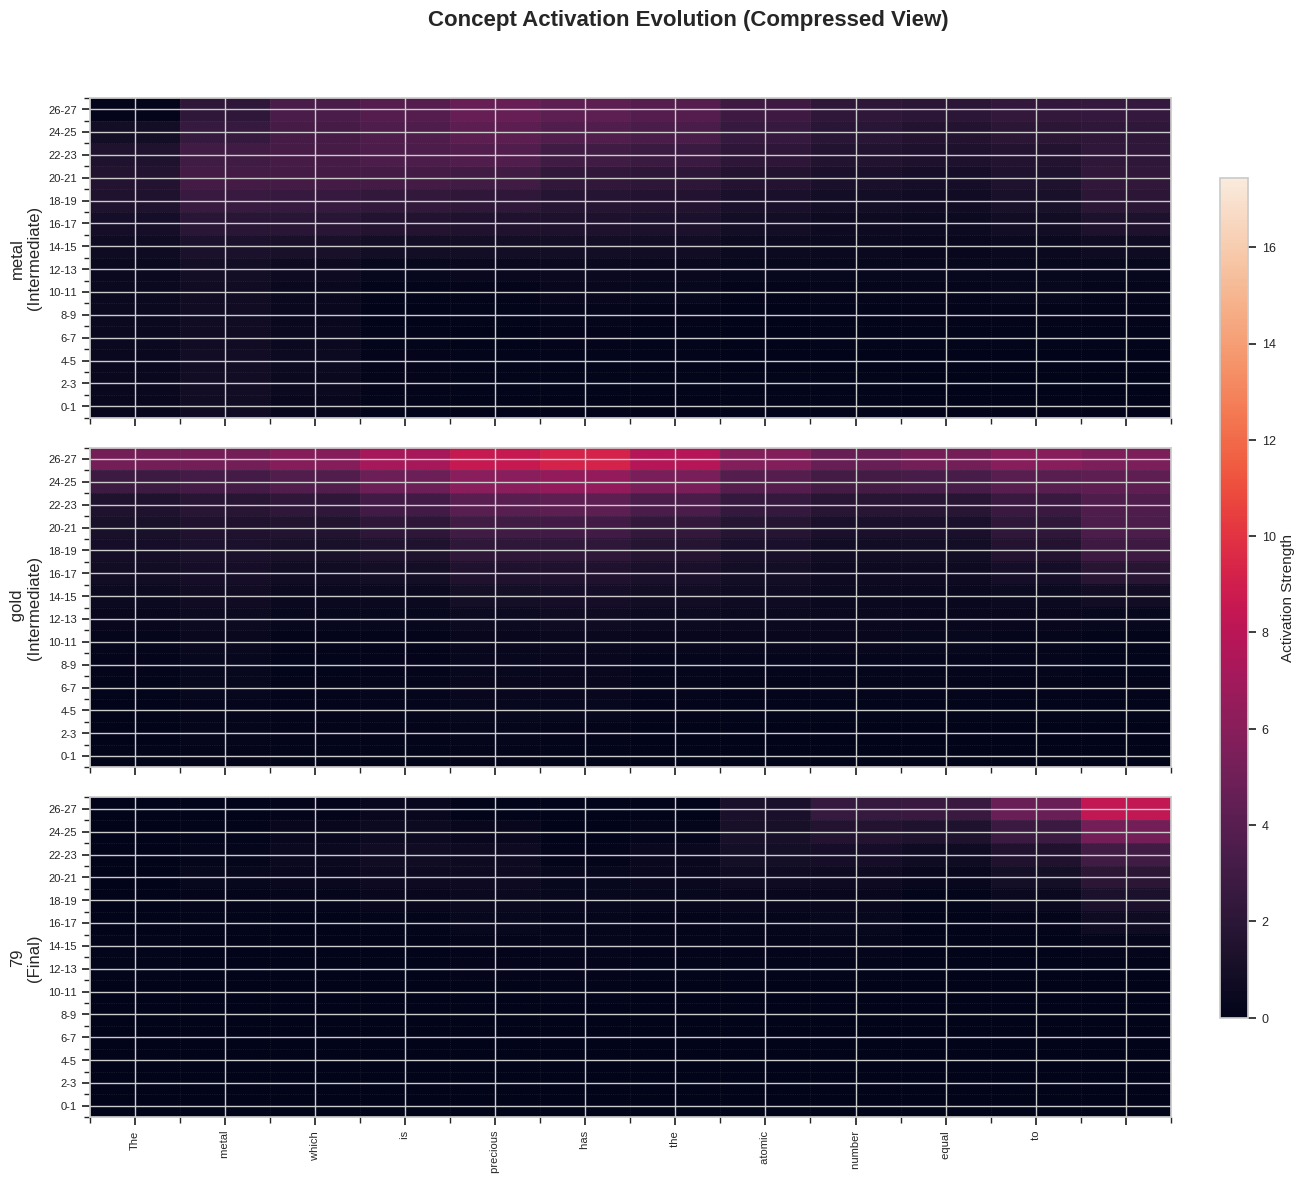

<Figure size 640x480 with 0 Axes>

In [11]:
# Visualize concept evolution
fig9 = plot_concept_activation_heatmap(logic_concept_results)
plt.tight_layout()
fig9.savefig("figures/logic_concept_evolution.png", dpi=300, bbox_inches='tight')
display(fig9)



In [12]:
# Animate concept activation for Gold
ani = animate_concept_activation_diagonal(logic_concept_results, selected_concepts=[" gold"])
display(HTML(ani.to_jshtml()))
ani.save("figures/gold_activation_diagonal.gif", writer=PillowWriter(fps=10), dpi=300)

In [13]:
# Animate concept activation for 79
ani = animate_concept_activation_diagonal(logic_concept_results, selected_concepts=["79"])
display(HTML(ani.to_jshtml()))
ani.save("figures/79_activation_diagonal.gif", writer=PillowWriter(fps=10), dpi=300)

### 🧠 Step 3: Tracing Reasoning Paths Across Layers


In [14]:
# Analyze reasoning paths
logic_path_results = analyze_reasoning_paths(
    model,
    logic_prompt,
    potential_paths=logic_paths,
    concept_threshold=0.05
)

# Print path scores
display(Markdown("### Reasoning Path Scores:"))
for path_data in logic_path_results["path_scores"]:
    path = path_data["path"]
    score = path_data["score"]
    complete = path_data.get("complete", False)
    in_order = path_data.get("in_order", False)

    path_str = " → ".join(path)
    status = ""
    if not complete:
        status = "(Missing concepts)"
    elif not in_order:
        status = "(Out of order)"

    display(Markdown(f"- **{path_str}**: {score:.4f} {status}"))

# Print best path
if logic_path_results["best_path"]:
    best_path = " → ".join(logic_path_results["best_path"])
    display(Markdown(f"**Best path:** {best_path} (score: {logic_path_results['best_path_score']:.4f})"))



### Reasoning Path Scores:

- **metal →  gold → 79**: 1.0000 

- **metal → 79**: 1.0000 

**Best path:** metal →  gold → 79 (score: 1.0000)

### 🎬 Step 4: Visualizing the Full Reasoning Trajectory


In [15]:
# Visualize reasoning path analysis
anim = animate_reasoning_flow(
    logic_path_results,
    tokens=tokens[1:],
    model_layers=model.cfg.n_layers
)
display(HTML(anim.to_jshtml()))



In [16]:
anim = save_animation(
    path_results=logic_path_results,
    tokens=tokens[1:],
    model_layers=model.cfg.n_layers,
    output_path="figures/reasoning_flow_logical_dark.gif",
    format="gif",
    fps=1,
    dpi=300
)

Animation saved to figures/reasoning_flow_logical_dark.gif
